In [2]:
import pandas as pd
import urllib.parse
def decode_url_and_remove_HTTPversion(encoded_url:str) -> str:
    return urllib.parse.unquote(str(encoded_url)).replace(" HTTP/1.1","").replace("GET /","/")
dataFrame:pd.DataFrame = pd.read_csv('./data/access.csv')
dataFrame = dataFrame[dataFrame['Referer'] != '-']
dataFrame['Request']=dataFrame['Request'].apply(decode_url_and_remove_HTTPversion)
dataFrame = dataFrame[dataFrame['Request'].str.contains('/browse/|/product/')]
dataFrame = dataFrame[~dataFrame['Request'].str.startswith('/image')]
dataFrame['Request'] = dataFrame['Request'].apply(lambda url: url.split('/')[-1])
dataFrame=dataFrame[dataFrame['Request']!='']
dataFrame['next_request'] = dataFrame.groupby('IP')['Request'].shift(-1)
dataFrame = dataFrame.dropna(subset=['next_request'])
#dataFrame=dataFrame.head(1000)

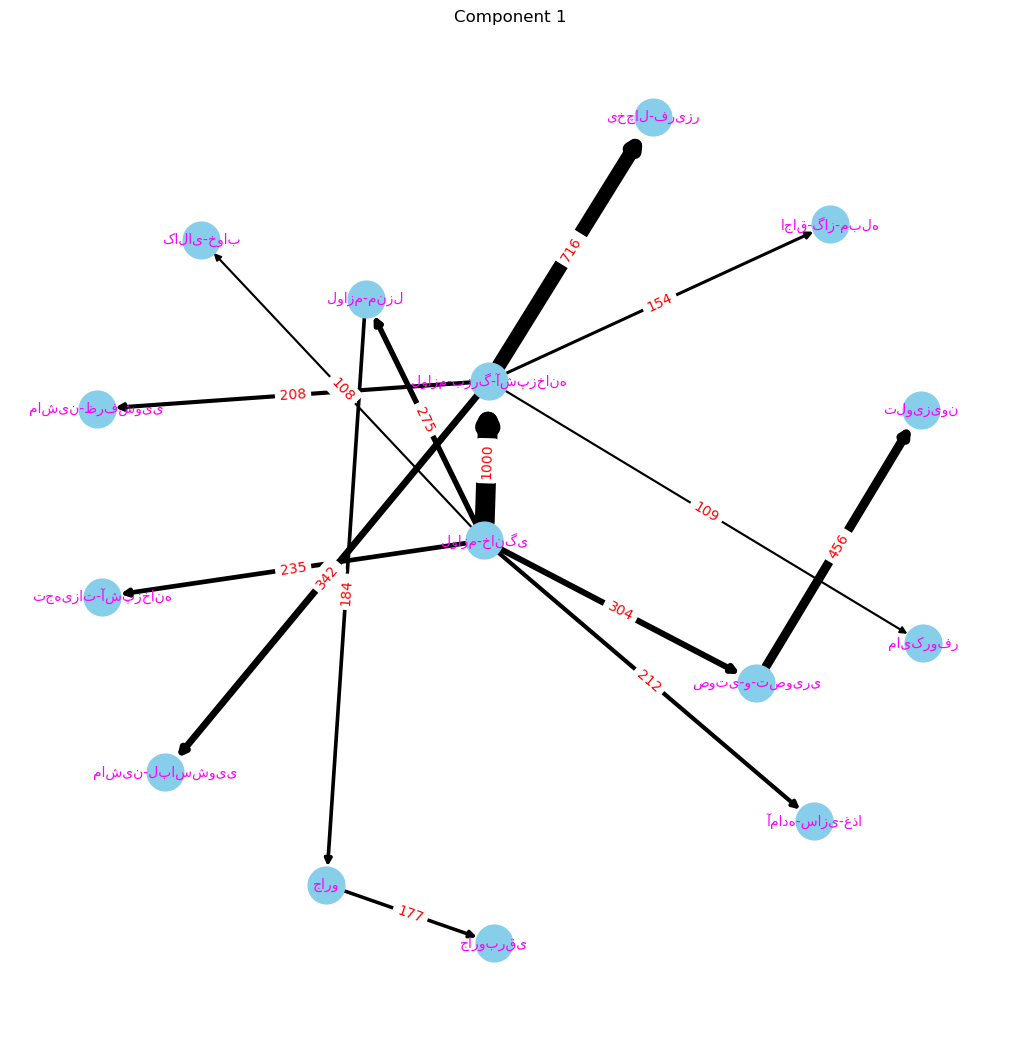

('لوازم-خانگی', 'لوازم-بزرگ-آشپزخانه'): 1000
('لوازم-بزرگ-آشپزخانه', 'یخچال-فریزر'): 716
('صوتی-و-تصویری', 'تلویزیون'): 456
('لوازم-بزرگ-آشپزخانه', 'ماشین-لباسشویی'): 342
('لوازم-خانگی', 'صوتی-و-تصویری'): 304
('لوازم-خانگی', 'لوازم-منزل'): 275
('لوازم-خانگی', 'تجهیزات-آشپزخانه'): 235
('لوازم-خانگی', 'آماده-سازی-غذا'): 212
('لوازم-بزرگ-آشپزخانه', 'ماشین-ظرفشویی'): 208
('لوازم-منزل', 'جارو'): 184
('جارو', 'جاروبرقی'): 177
('لوازم-بزرگ-آشپزخانه', 'اجاق-گاز-مبله'): 154
('لوازم-بزرگ-آشپزخانه', 'مایکروفر'): 109
('لوازم-خانگی', 'کالای-خواب'): 108


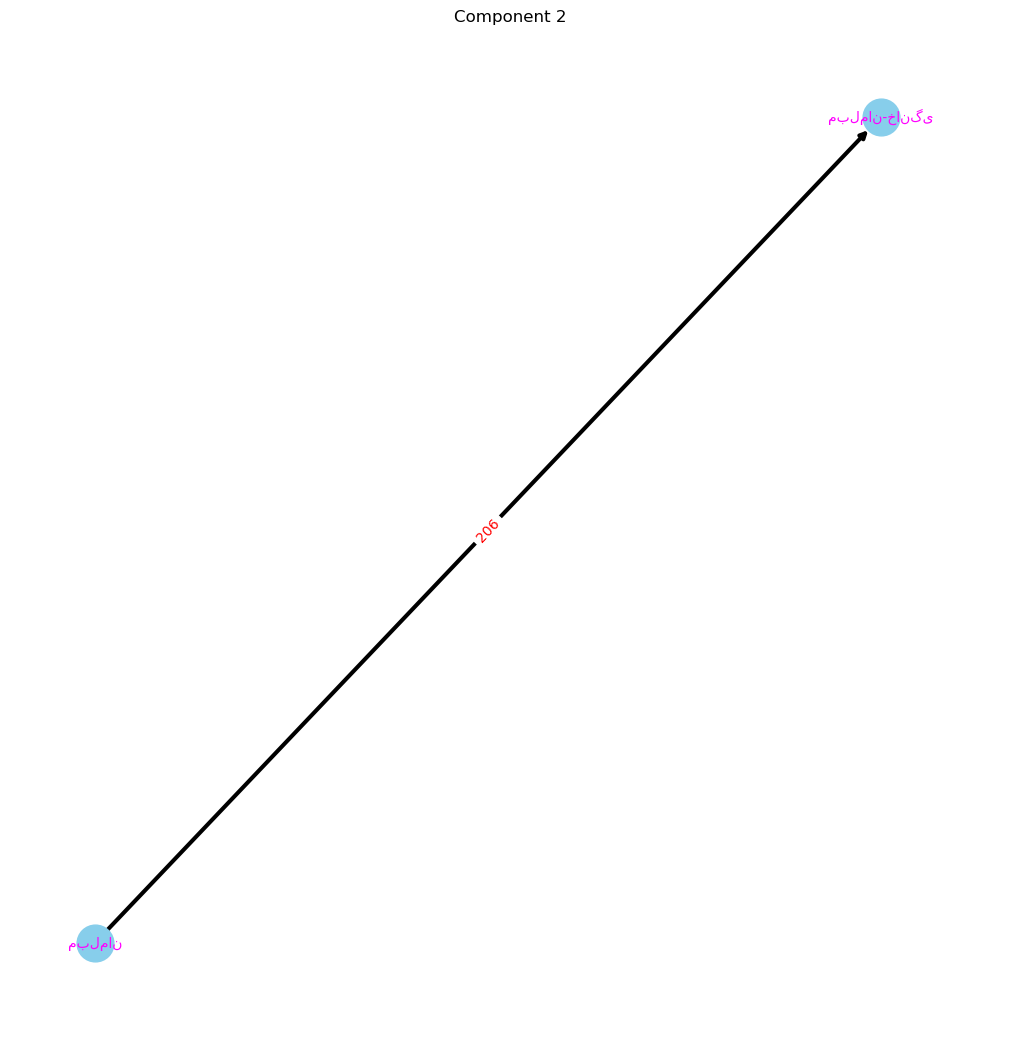

('مبلمان', 'مبلمان-خانگی'): 206


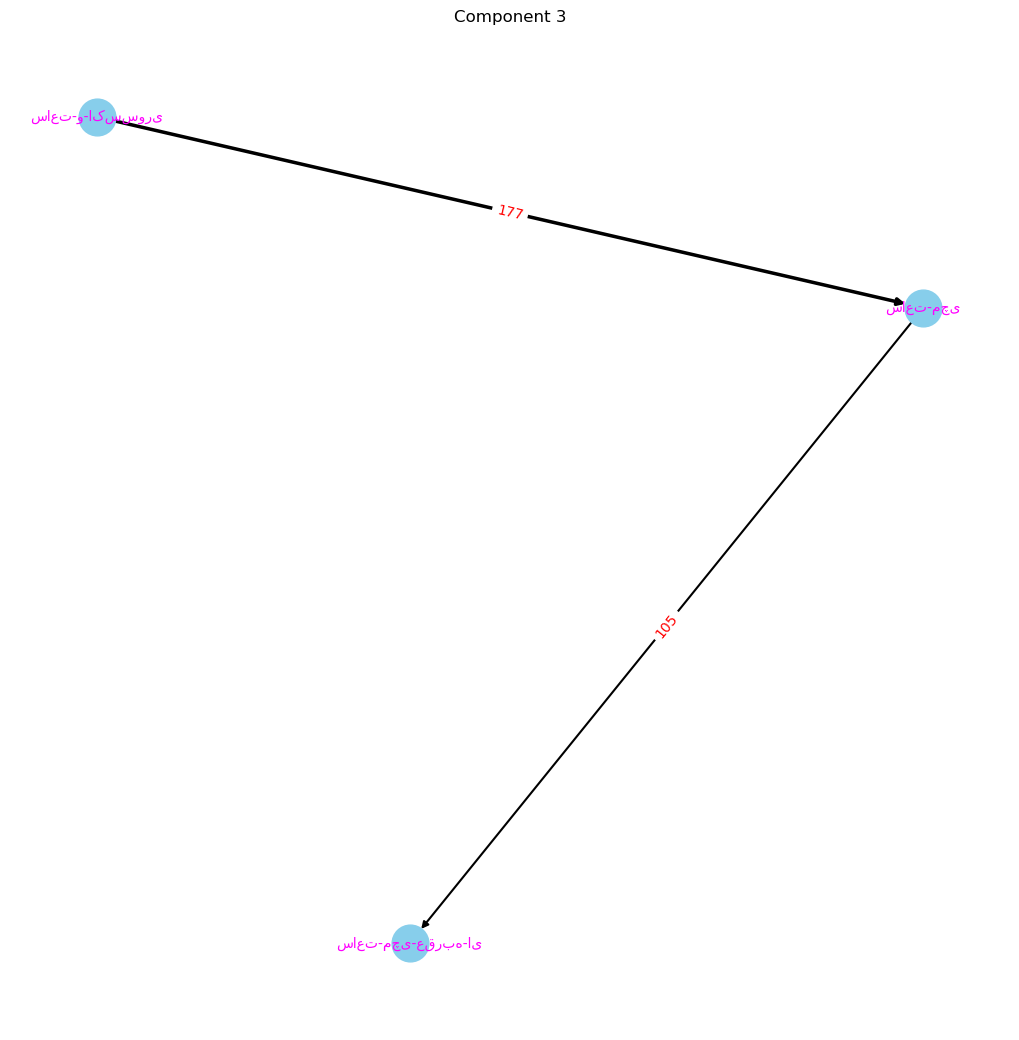

('ساعت-و-اکسسوری', 'ساعت-مچی'): 177
('ساعت-مچی', 'ساعت-مچی-عقربه-ای'): 105


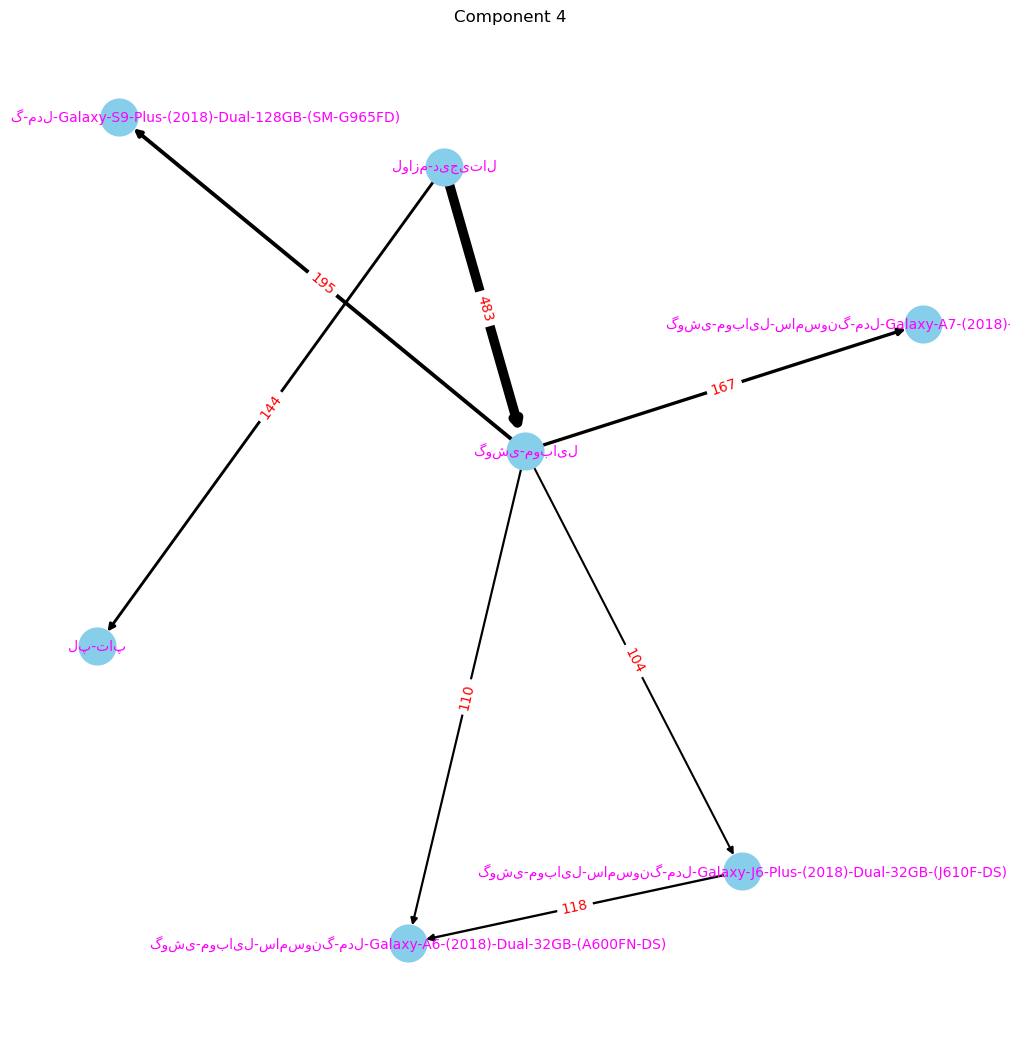

('لوازم-دیجیتال', 'گوشی-موبایل'): 483
('گوشی-موبایل', 'گوشی-موبایل-سامسونگ-مدل-Galaxy-S9-Plus-(2018)-Dual-128GB-(SM-G965FD)'): 195
('گوشی-موبایل', 'گوشی-موبایل-سامسونگ-مدل-Galaxy-A7-(2018)-Dual-128GB-(A750F-DS)'): 167
('لوازم-دیجیتال', 'لپ-تاپ'): 144
('گوشی-موبایل-سامسونگ-مدل-Galaxy-J6-Plus-(2018)-Dual-32GB-(J610F-DS)', 'گوشی-موبایل-سامسونگ-مدل-Galaxy-A6-(2018)-Dual-32GB-(A600FN-DS)'): 118
('گوشی-موبایل', 'گوشی-موبایل-سامسونگ-مدل-Galaxy-A6-(2018)-Dual-32GB-(A600FN-DS)'): 110
('گوشی-موبایل', 'گوشی-موبایل-سامسونگ-مدل-Galaxy-J6-Plus-(2018)-Dual-32GB-(J610F-DS)'): 104


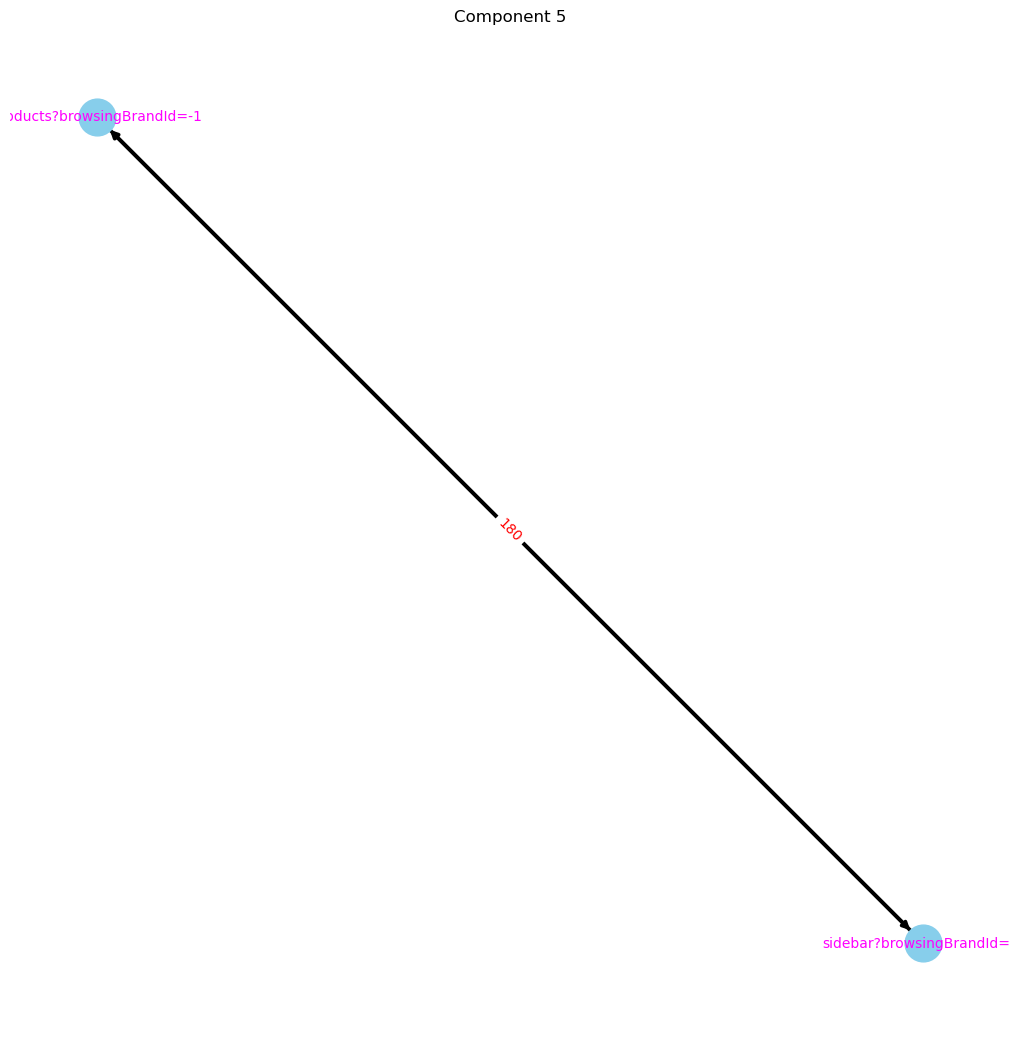

('sidebar?browsingBrandId=-1', 'products?browsingBrandId=-1'): 191
('products?browsingBrandId=-1', 'sidebar?browsingBrandId=-1'): 180


In [29]:

# 学習、予測
import networkx as nx
import matplotlib.pyplot as plt
import time
# 最小カウントを設定
minimumCount =100
# エッジのリストを作成し、遷移の数をカウント
transition_counts = dataFrame.groupby(['Request', 'next_request']).size().reset_index(name='count')
# グラフを作成し、エッジの属性として遷移の数を格納
G = nx.DiGraph()
for _, row in transition_counts.iterrows():
    if row['Request'] != row['next_request']:
        G.add_edge(row['Request'], row['next_request'], weight=row['count'])
# エッジの重みが最小カウント以上のものだけをフィルタリング
filtered_edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if d.get('weight', 0) >= minimumCount]
G_filtered = nx.DiGraph()
G_filtered.add_weighted_edges_from(filtered_edges)
components = list(nx.weakly_connected_components(G_filtered))
for i, nodes in enumerate(components):
    H = G_filtered.subgraph(nodes)
    plt.figure(figsize=(10, 10))
    pos_filtered = nx.spring_layout(H, k=30, iterations=200)
    edge_weights = nx.get_edge_attributes(H, 'weight')
    edge_widths = [weight / 70 for weight in edge_weights.values()]
    nx.draw(H, pos_filtered, with_labels=True, node_size=700, node_color='skyblue', font_size=10,  width=edge_widths,font_color='magenta')
    nx.draw_networkx_edge_labels(H, pos=pos_filtered, edge_labels=edge_weights,font_color='red')
    plt.title(f'Component {i+1}')
    plt.show()
    edge_weights = nx.get_edge_attributes(H, 'weight')
    sorted_edges = sorted(edge_weights.items(), key=lambda item: item[1], reverse=True)
    for edge, weight in sorted_edges:
        print(f"{edge}: {weight}")
    

